> Try to divide train and test(GNAR fivenet)

In [1]:
def vis(STdata):
    N = STdata.shape[1]
    fig, ax = plt.subplots(5,1,(15,5))
    for n in range(N):
        ax[n].plot(fiveVTS[:,0])
    #fig.set_width()
    fig.set_height(N*5) 
    return fig 

# import

In [2]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [3]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer



# Data

In [6]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [7]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

# functions 

In [90]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [91]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [92]:
edges_tensor = torch.tensor(edges)

In [93]:
nonzero_indices = edges_tensor.nonzero()

In [94]:
fiveNet_edge = np.array(nonzero_indices).T

In [95]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [96]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

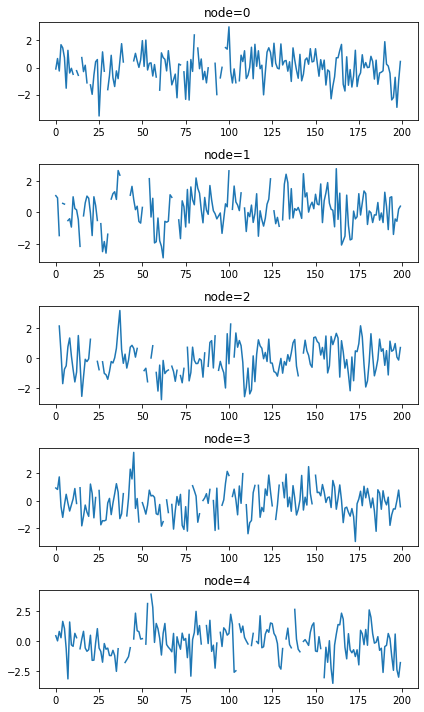

In [97]:
vis(fiveVTS);

In [98]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

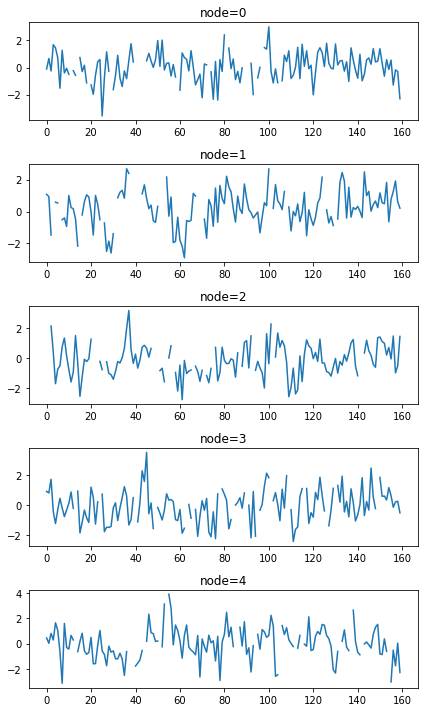

In [99]:
vis(fiveVTS_train);

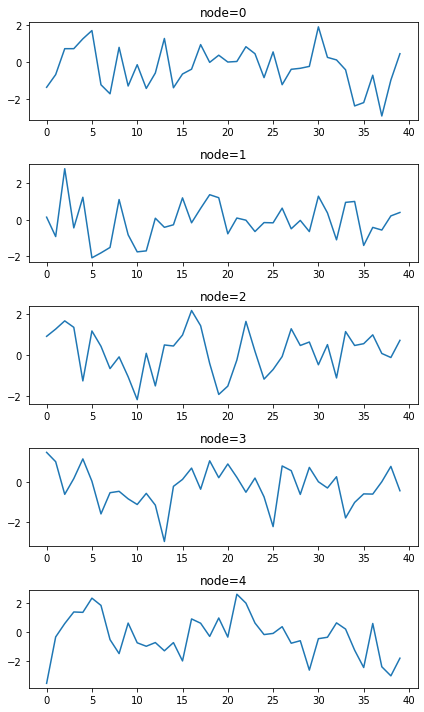

In [100]:
vis(fiveVTS_test);

# Random Missing Values

In [101]:
np.random.seed(1)
seed_number1 = np.random.choice(159,16,replace=False)

In [102]:
np.random.seed(3)
seed_number2 = np.random.choice(159,16,replace=False)

In [103]:
np.random.seed(5)
seed_number3 = np.random.choice(159,16,replace=False)

In [104]:
np.random.seed(7)
seed_number4 = np.random.choice(159,16,replace=False)

In [105]:
np.random.seed(9)
seed_number5 = np.random.choice(159,16,replace=False)

In [106]:
fiveVTS_train_backup = fiveVTS_train.copy()

In [107]:
fiveVTS_train[seed_number1,0] = float('nan')

In [108]:
fiveVTS_train[seed_number2,1] = float('nan')

In [109]:
fiveVTS_train[seed_number3,2] = float('nan')

In [110]:
fiveVTS_train[seed_number4,3] = float('nan')

In [111]:
fiveVTS_train[seed_number5,4] = float('nan')

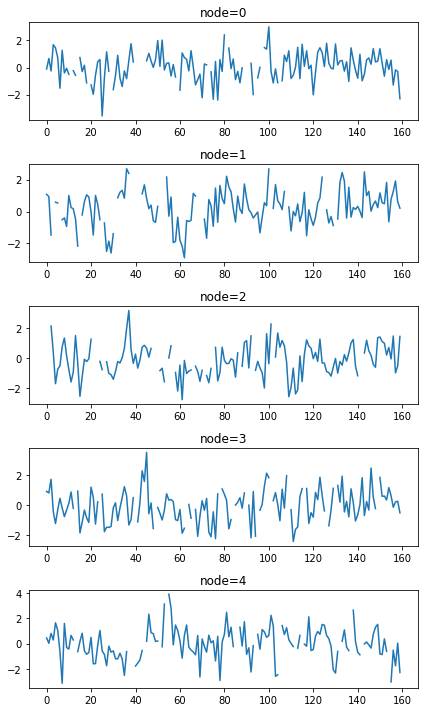

In [112]:
vis(fiveVTS_train);

# 1. Mean

In [113]:
fiveVTS_train_mean = fiveVTS_train.copy()

In [114]:
fiveVTS_train_mean[seed_number1,0] = np.nanmean(fiveVTS_train_mean[:,0])

In [115]:
fiveVTS_train_mean[seed_number2,1] = np.nanmean(fiveVTS_train_mean[:,1])

In [116]:
fiveVTS_train_mean[seed_number3,2] = np.nanmean(fiveVTS_train_mean[:,2])

In [117]:
fiveVTS_train_mean[seed_number4,3] = np.nanmean(fiveVTS_train_mean[:,3])

In [118]:
fiveVTS_train_mean[seed_number5,4] = np.nanmean(fiveVTS_train_mean[:,4])

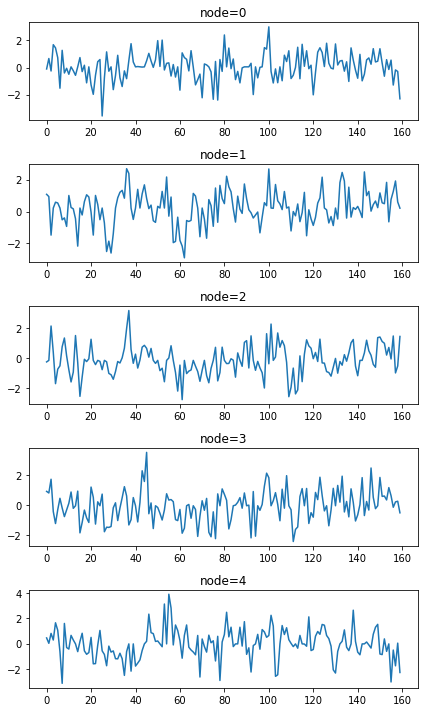

In [119]:
vis(fiveVTS_train_mean);

## 1) ST-GCN

In [120]:
mean_f_fiveVTS_train = torch.tensor(fiveVTS_train_mean).reshape(160,5,1).float()

In [121]:
mean_X_fiveVTS = mean_f_fiveVTS_train[:159,:,:]
mean_y_fiveVTS = mean_f_fiveVTS_train[1:,:,:]

In [122]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [123]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [124]:
xt_test = torch.tensor(fiveVTS_test.reshape(40,5,1)[:-1,:,:]).float()

In [125]:
mean_fhat_fiveVTS_forecast = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

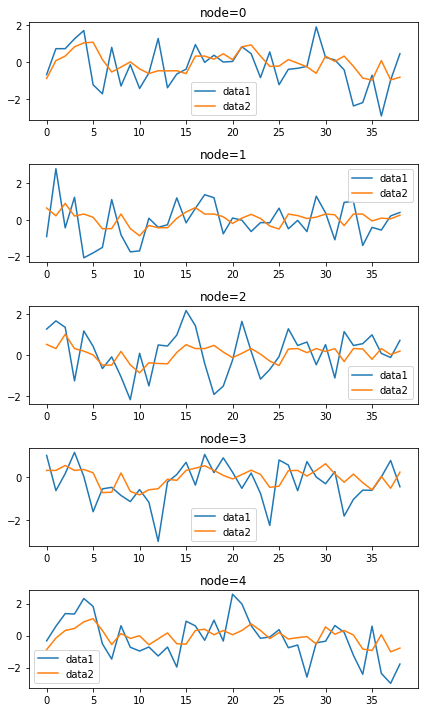

In [126]:
vis2(fiveVTS_test[1:],mean_fhat_fiveVTS_forecast);

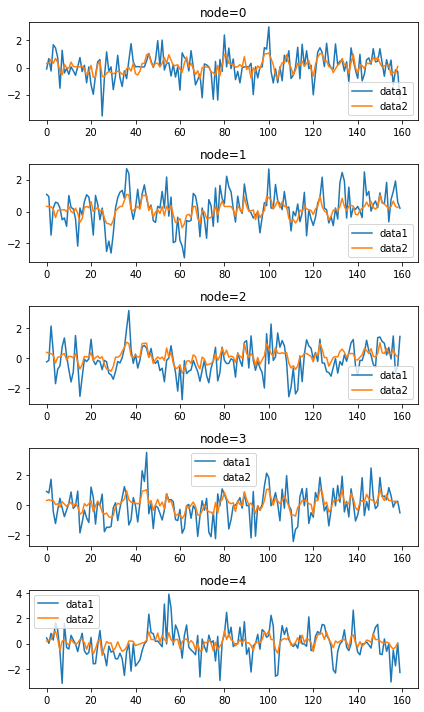

In [127]:
vis2(fiveVTS_train_mean,mean_fhat_fiveVTS);

## 2) Fourier transform

In [128]:
w=np.zeros((159*N,159*N))

In [129]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [130]:
# np.fft(mean_fhat_fiveVTS[:,0,0])

In [131]:
# mean_fhat_fiveVTS.shape

In [132]:
# fft_result =np.stack([np.fft.fft(mean_fhat_fiveVTS[:,n,0]) for n in range(N)]).T

In [133]:
# plt.plot(abs(fft_result[:,0])**2)

In [134]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [135]:
fhatbar = Psi.T @ mean_fhat_fiveVTS.reshape(159*N,1)

## 3) Ebayes

In [136]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

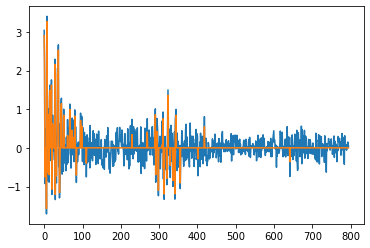

In [137]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 4) Inverse Fourier transform

In [138]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

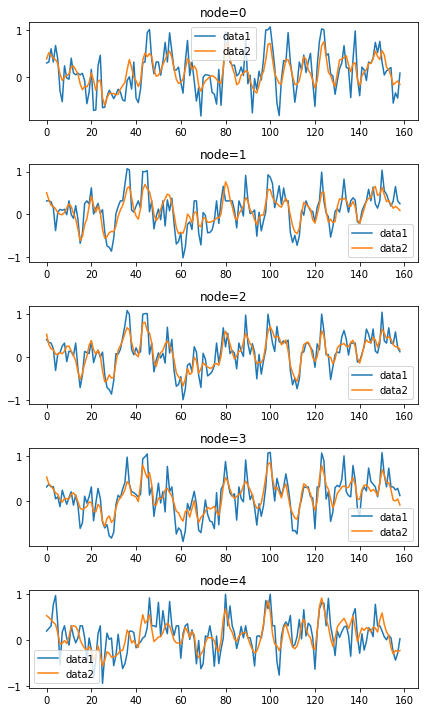

In [139]:
vis2(mean_fhat_fiveVTS,fhatbarhat_mean_spatio_temporal.reshape(159,5));

## 5) ST-GCN

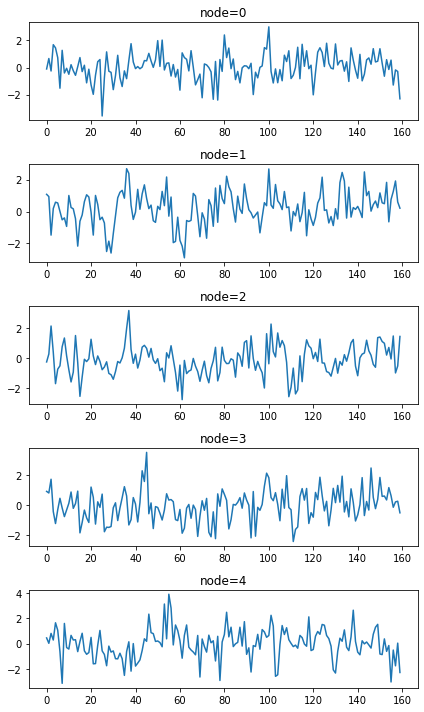

In [140]:
fiveVTS_train_mean[seed_number1,0] = fhatbarhat_mean_spatio_temporal[seed_number1,0,0]
fiveVTS_train_mean[seed_number2,1] = fhatbarhat_mean_spatio_temporal[seed_number2,1,0]
fiveVTS_train_mean[seed_number3,2] = fhatbarhat_mean_spatio_temporal[seed_number3,2,0]
fiveVTS_train_mean[seed_number4,3] = fhatbarhat_mean_spatio_temporal[seed_number4,3,0]
fiveVTS_train_mean[seed_number5,4] = fhatbarhat_mean_spatio_temporal[seed_number5,4,0]
vis(fiveVTS_train_mean);

In [141]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [142]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [143]:
mean_fhat_spatio_temporal_test = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

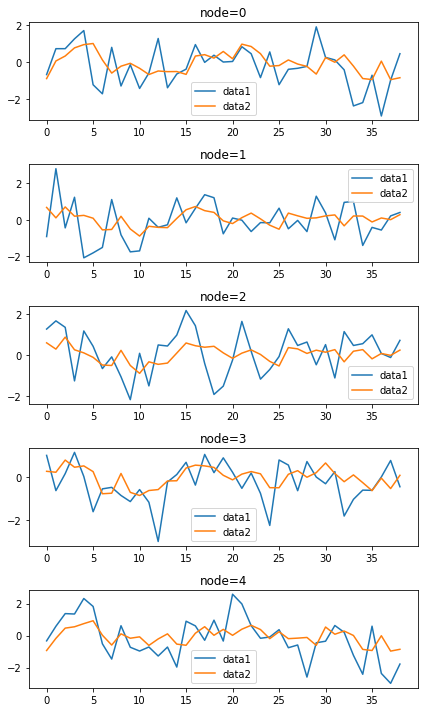

In [144]:
vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test);

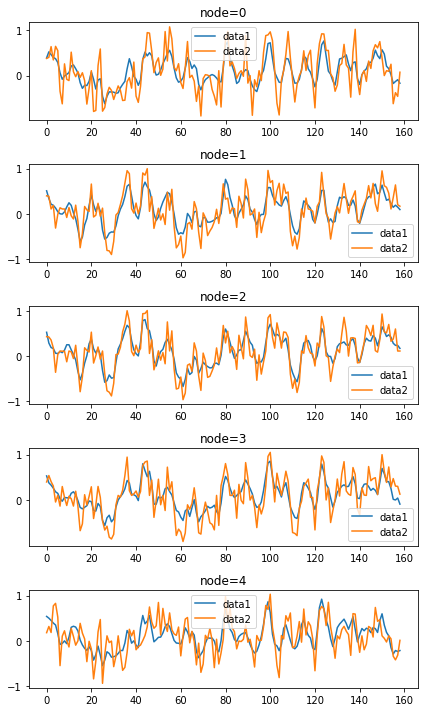

In [145]:
vis2(fhatbarhat_mean_spatio_temporal,mean_fhat_spatio_temporal);

---

In [146]:
for i in tqdm(range(50)):
    ## GFT 
    fhatbar = Psi.T @ mean_fhat_fiveVTS.reshape(159*N,1)

    ## Ebayes
    ebayesthresh = importr('EbayesThresh').ebayesthresh
    fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))
    #plt.plot(fhatbar)
    #plt.plot(fhatbar_threshed)

    ## inverse GFT 
    fhatbarhat = Psi @ fhatbar_threshed
    fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)
    #vis2(mean_fhat_fiveVTS,fhatbarhat_mean_spatio_temporal.reshape(159,5));

    ## STGCN 
    fiveVTS_train_mean[seed_number1,0] = fhatbarhat_mean_spatio_temporal[seed_number1,0,0]
    fiveVTS_train_mean[seed_number2,1] = fhatbarhat_mean_spatio_temporal[seed_number1,1,0]
    fiveVTS_train_mean[seed_number3,2] = fhatbarhat_mean_spatio_temporal[seed_number1,2,0]
    fiveVTS_train_mean[seed_number4,3] = fhatbarhat_mean_spatio_temporal[seed_number1,3,0]
    fiveVTS_train_mean[seed_number5,4] = fhatbarhat_mean_spatio_temporal[seed_number1,4,0]
    #vis(fiveVTS_train_mean);

    #model = RecurrentGCN(node_features=1, filters=4)

    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    #model.train()
    for epoch in range(1):
        for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
            y_hat = model(xt, edge_index, edge_attr)
            cost = torch.mean((y_hat-yt)**2)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()

    mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()
    mean_fhat_spatio_temporal_test = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()
    #vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test);
    #vis2(fiveVTS_train_backup,mean_fhat_spatio_temporal);

100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


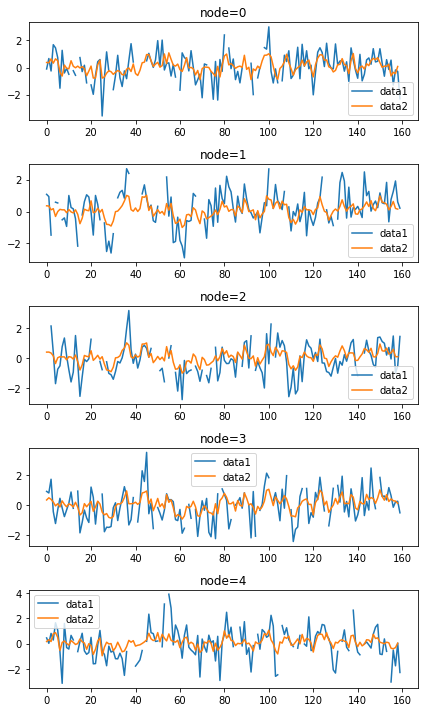

In [147]:
vis2(fiveVTS_train_backup,mean_fhat_spatio_temporal);

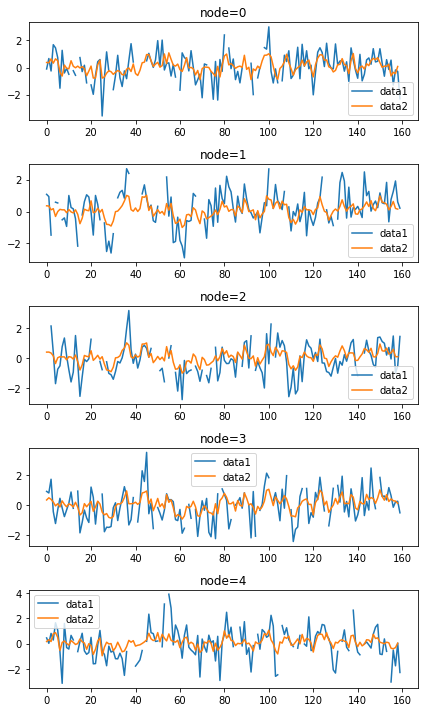

In [148]:
vis2(fiveVTS_train_backup,mean_fhat_spatio_temporal);

---

## 6) Fourier transform

In [149]:
w=np.zeros((159*N,159*N))

In [150]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [151]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [152]:
fhatbar = Psi.T @ mean_fhat_spatio_temporal.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [153]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

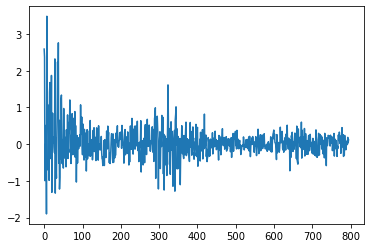

In [154]:
plt.plot(fhatbar)

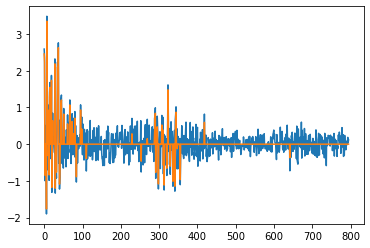

In [155]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 8) Inverse Fourier transform

In [156]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal2 = fhatbarhat.reshape(159,N,1)

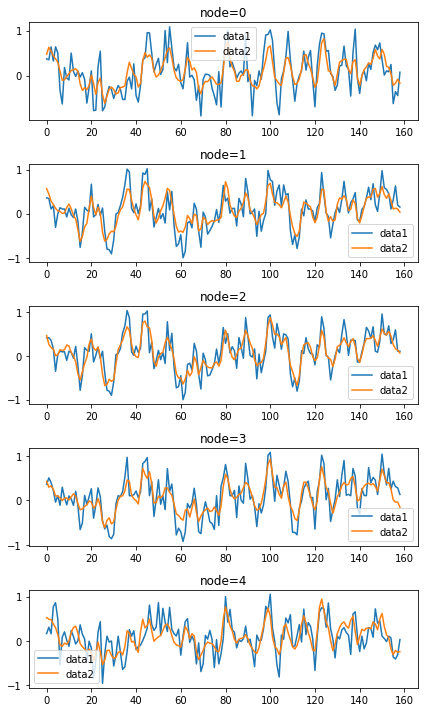

In [157]:
vis2(mean_fhat_spatio_temporal,fhatbarhat_mean_spatio_temporal2.reshape(159,5));

## 9) ST-GCN

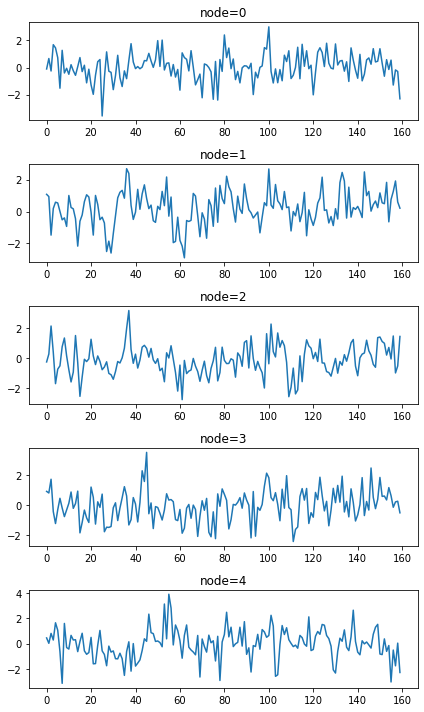

In [158]:
fiveVTS_train_mean[seed_number1,0] = fhatbarhat_mean_spatio_temporal[seed_number1,0,0]
fiveVTS_train_mean[seed_number2,1] = fhatbarhat_mean_spatio_temporal[seed_number2,1,0]
fiveVTS_train_mean[seed_number3,2] = fhatbarhat_mean_spatio_temporal[seed_number3,2,0]
fiveVTS_train_mean[seed_number4,3] = fhatbarhat_mean_spatio_temporal[seed_number4,3,0]
fiveVTS_train_mean[seed_number5,4] = fhatbarhat_mean_spatio_temporal[seed_number5,4,0]
vis(fiveVTS_train_mean);

In [159]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [160]:
mean_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [161]:
mean_fhat_spatio_temporal_test2 = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

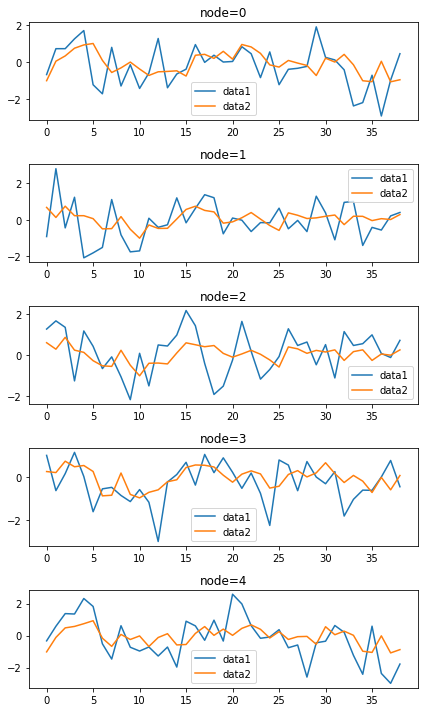

In [162]:
vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test2);

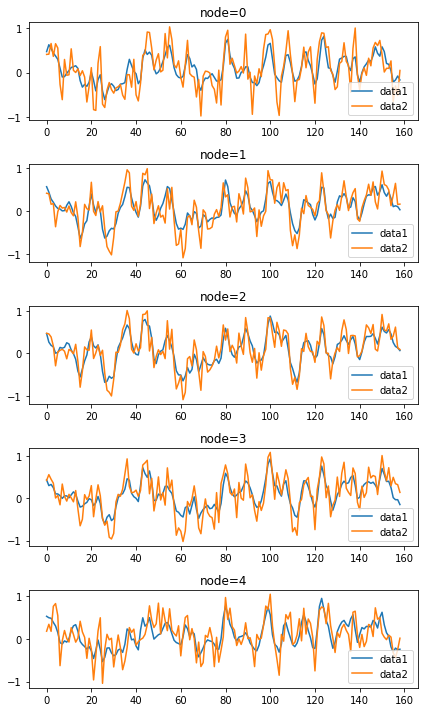

In [163]:
vis2(fhatbarhat_mean_spatio_temporal2,mean_fhat_spatio_temporal2);

## 10) Fourier transform

In [164]:
w=np.zeros((159*N,159*N))

In [165]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [166]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [167]:
fhatbar = Psi.T @ mean_fhat_spatio_temporal.reshape(159*N,1)
power = fhatbar**2 

## 11) Ebayes

In [168]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

## 12) Inverse Fourier transform

In [169]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal3 = fhatbarhat.reshape(159,N,1)

## 13) ST-GCN

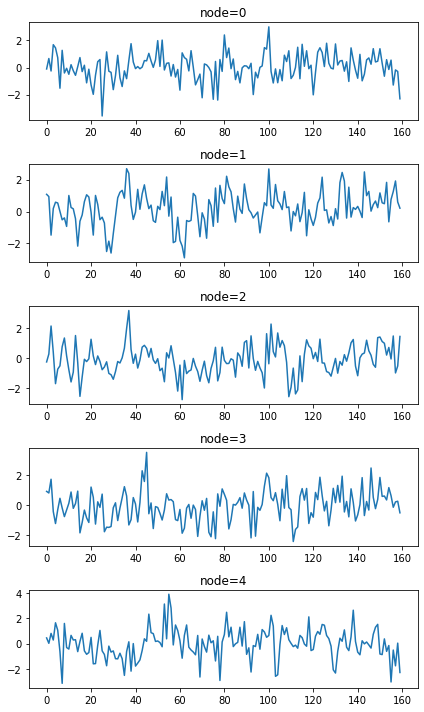

In [170]:
fiveVTS_train_mean[seed_number1,0] = fhatbarhat_mean_spatio_temporal[seed_number1,0,0]
fiveVTS_train_mean[seed_number2,1] = fhatbarhat_mean_spatio_temporal[seed_number2,1,0]
fiveVTS_train_mean[seed_number3,2] = fhatbarhat_mean_spatio_temporal[seed_number3,2,0]
fiveVTS_train_mean[seed_number4,3] = fhatbarhat_mean_spatio_temporal[seed_number4,3,0]
fiveVTS_train_mean[seed_number5,4] = fhatbarhat_mean_spatio_temporal[seed_number5,4,0]
vis(fiveVTS_train_mean);

In [171]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [172]:
mean_fhat_spatio_temporal3 = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [173]:
mean_fhat_spatio_temporal_test3 = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

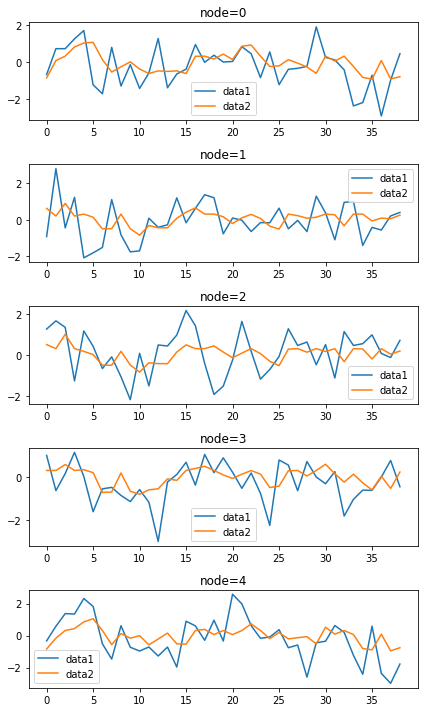

In [174]:
vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test3);

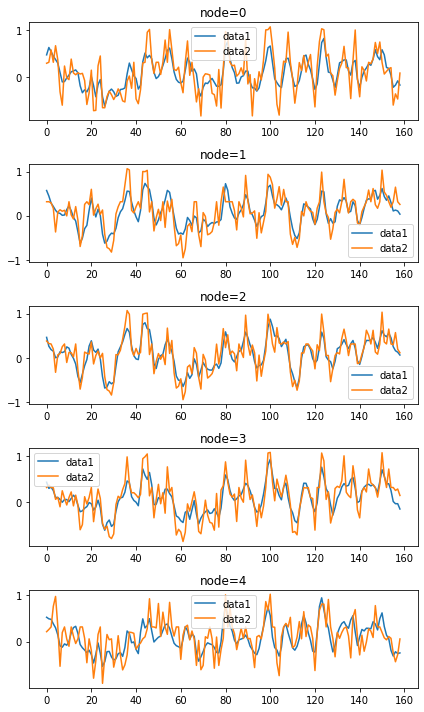

In [175]:
vis2(fhatbarhat_mean_spatio_temporal3,mean_fhat_spatio_temporal3);

In [176]:
one = []
for i in range(N):
    one.append(np.mean((fiveVTS_test[1:,i] - mean_fhat_fiveVTS_forecast.reshape(39,5)[:,i])))

In [177]:
two = []
for i in range(N):
    two.append(np.mean((fiveVTS_test[1:,i] - mean_fhat_spatio_temporal_test.reshape(39,5)[:,i])))

In [178]:
three = []
for i in range(N):
    three.append(np.mean((fiveVTS_test[1:,i] - mean_fhat_spatio_temporal_test2.reshape(39,5)[:,i])))

In [179]:
four = []
for i in range(N):
    four.append(np.mean((fiveVTS_test[1:,i] - mean_fhat_spatio_temporal_test3.reshape(39,5)[:,i])))

In [180]:
pd.DataFrame({'one':one,'two':two,'three':three,'four':four})

,one,two,three,four
0,-0.196310,-0.189000,-0.173563,-0.200559
1,-0.161632,-0.135003,-0.142250,-0.159892
2,0.079347,0.106893,0.108179,0.079011
3,-0.267653,-0.244438,-0.248220,-0.269292
4,-0.162464,-0.135709,-0.130221,-0.167336


# 2. Linear Interpolation

In [ ]:
_df = pd.DataFrame(fiveVTS_train)
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [ ]:
linear_fiveVTS_train = np.array(_df).reshape(160,5)

## 1) ST-GCN

In [ ]:
linear_f_fiveVTS_train = torch.tensor(linear_fiveVTS_train).reshape(160,5,1).float()

In [ ]:
linear_X_fiveVTS = linear_f_fiveVTS_train[:159,:,:]
linear_y_fiveVTS = linear_f_fiveVTS_train[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_fiveVTS,linear_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fiveVTS]).detach().numpy()

In [ ]:
xt_test = torch.tensor(fiveVTS_test.reshape(40,5,1)[:-1,:,:]).float()

In [ ]:
linear_fhat_fiveVTS_forecast = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

In [ ]:
vis2(fiveVTS_test[1:],linear_fhat_fiveVTS_forecast);

In [ ]:
vis2(linear_fiveVTS_train,linear_f_fiveVTS_train);

## 2) Fourier transform

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [ ]:
fhatbar = Psi.T @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

In [ ]:
plt.plot(fhatbar.reshape(159,5)[:,0]**2)

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

In [ ]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 4) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

In [ ]:
vis2(linear_fhat_fiveVTS,fhatbarhat_linear_spatio_temporal.reshape(159,5));

## 5) ST-GCN

In [ ]:
linear_spatio_temporal = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [ ]:
linear_X_spatio_temporal = linear_spatio_temporal[:158,:,:]
linear_y_spatio_temporal = linear_spatio_temporal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal,linear_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal]).detach().numpy()

In [ ]:
linear_fhat_spatio_temporal_test = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

In [ ]:
vis2(fiveVTS_test[1:],linear_fhat_spatio_temporal_test);

In [ ]:
vis2(fhatbarhat_linear_spatio_temporal,linear_fhat_spatio_temporal);

## 6) Fourier transform

In [ ]:
w=np.zeros((158*N,158*N))

In [ ]:
for i in range(158*N):
    for j in range(158*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [ ]:
fhatbar = Psi.T @ linear_fhat_spatio_temporal.reshape(158*N,1)
power = fhatbar**2 

## 7) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

In [ ]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 8) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal2 = fhatbarhat.reshape(158,N,1)

In [ ]:
vis2(linear_fhat_spatio_temporal,fhatbarhat_linear_spatio_temporal2.reshape(158,5));

## 9) ST-GCN

In [ ]:
linear_spatio_temporal2 = torch.tensor(fhatbarhat_linear_spatio_temporal2).reshape(158,5,1).float()

In [ ]:
linear_X_spatio_temporal2 = linear_spatio_temporal2[:157,:,:]
linear_y_spatio_temporal2 = linear_spatio_temporal2[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal2,linear_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal2]).detach().numpy()

In [ ]:
linear_fhat_spatio_temporal_test2 = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

In [ ]:
vis2(fiveVTS_test[1:],linear_fhat_spatio_temporal_test2);

In [ ]:
vis2(fhatbarhat_linear_spatio_temporal2,linear_fhat_spatio_temporal2);

In [ ]:
one = []
for i in range(N):
    one.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_fiveVTS_forecast.reshape(39,5)[:,i])))

In [ ]:
two = []
for i in range(N):
    two.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_spatio_temporal_test.reshape(39,5)[:,i])))

In [ ]:
three = []
for i in range(N):
    three.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_spatio_temporal_test2.reshape(39,5)[:,i])))

In [ ]:
pd.DataFrame({'one':one,'two':two,'three':three})

## 10) Fourier transform

In [ ]:
w=np.zeros((157*N,157*N))

In [ ]:
for i in range(157*N):
    for j in range(157*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [ ]:
fhatbar = Psi.T @ linear_fhat_spatio_temporal2.reshape(157*N,1)

## 11) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

In [ ]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 12) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal3 = fhatbarhat.reshape(157,N,1)

In [ ]:
vis2(linear_fhat_spatio_temporal2,fhatbarhat_linear_spatio_temporal3.reshape(157,5));

## 13) ST-GCN

In [ ]:
linear_spatio_temporal3 = torch.tensor(fhatbarhat_linear_spatio_temporal3).reshape(157,5,1).float()

In [ ]:
linear_X_spatio_temporal3 = linear_spatio_temporal3[:156,:,:]
linear_y_spatio_temporal3 = linear_spatio_temporal3[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal3,linear_y_spatio_temporal3)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_spatio_temporal3 = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal3]).detach().numpy()

In [ ]:
linear_fhat_spatio_temporal_test3 = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

In [ ]:
vis2(fiveVTS_test[1:],linear_fhat_spatio_temporal_test3);

In [ ]:
vis2(fhatbarhat_linear_spatio_temporal3,linear_fhat_spatio_temporal3);

In [ ]:
one = []
for i in range(N):
    one.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_fiveVTS_forecast.reshape(39,5)[:,i])))

In [ ]:
two = []
for i in range(N):
    two.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_spatio_temporal_test.reshape(39,5)[:,i])))

In [ ]:
three = []
for i in range(N):
    three.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_spatio_temporal_test2.reshape(39,5)[:,i])))

In [ ]:
four = []
for i in range(N):
    four.append(np.mean((fiveVTS_test[1:,i] - linear_fhat_spatio_temporal_test3.reshape(39,5)[:,i])))

In [ ]:
pd.DataFrame({'one':one,'two':two,'three':three,'four':four})

# 3. GNAR

**mean**

In [181]:
%R -i fiveVTS_train_mean

In [182]:
%%R
meanprediction <- predict(GNARfit(vts = fiveVTS_train_mean[1:160,], net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1)),n.ahead=40)

In [183]:
%R -o meanprediction

In [185]:
a = []
for i in range(40):
    a.append((meanprediction.reshape(40,5)[i] -  fiveVTS_test[i]))

In [192]:
((pd.DataFrame(a))**2).mean(axis=0)

0    1.256051
1    1.083987
2    1.117363
3    0.952564
4    1.943335
dtype: float64

In [193]:
((pd.DataFrame(a))**2).mean(axis=0).mean()

1.270659819100067